In [5]:
!pip install  lightning-bolts==0.6.0.post1
!pip install  lightning-lite==1.8.0
!pip install  lightning-utilities==0.3.0
!pip install  pytorch-lightning==1.8.0


In [6]:
#!pip uninstall -y pytorch-lightning
#!pip uninstall -y lightning-bolts
#!pip uninstall -y lightning-lite
#!pip uninstall -y lightning-utilities


In [7]:
!pip install torch==1.13.0

In [8]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [9]:
import pytorch_lightning as pl
#import  pl_bolts
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.pre_conv = nn.Conv2d(1,3,3, padding=3)
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)
        self.one_hot_linear = nn.Linear(10,3072)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, label = batch
        #print(batch)
        x, label = x.to(device), label.to(device)
        
        #x = self.pre_conv(x)
        
        #print(x.shape)
        # encode x to get the mu and variance parameters
        label_one_hot = F.one_hot(label, num_classes=10)
        label_one_hot = label_one_hot.to(device)
        label_one_hot = label_one_hot.to(torch.float32)
        label_high  =self.one_hot_linear(label_one_hot)
        label_high = label_high.view_as(x)
        x = x + label_high
        #print(x.shape)
        x_encoded = self.encoder(x)
        #print("x_snc", x_encoded.shape)


        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        #print("myu", mu.shape, log_var.shape)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        #print("z",z.shape)

        # decoded 
        x_hat = vae.decoder(z)
        #print("dec", x_hat.shape)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

/opt/conda/lib/python3.7/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/opt/conda/lib/python3.7/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapContr

In [10]:
from pl_bolts.datamodules import MNISTDataModule

datamodule = MNISTDataModule('.', pin_memory=True, batch_size=32)

In [11]:
from pl_bolts.datamodules import CIFAR10DataModule

datamodule = CIFAR10DataModule('.', pin_memory=False, batch_size=32)

In [12]:
pl.seed_everything(1234)
import torch
vae = VAE().to(device)
trainer = pl.Trainer(gpus=1, max_epochs=15, accelerator = 'cuda')
trainer.fit(vae, datamodule)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
/opt/conda/lib/python3.7/site-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
/opt/conda/lib/python3.7/site-packages/pl_bolts/models/autoencoders/components.py:236: UnderReviewWarning: The fea

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

torch.Size([9, 3, 32, 32])
torch.Size([3, 70, 274])


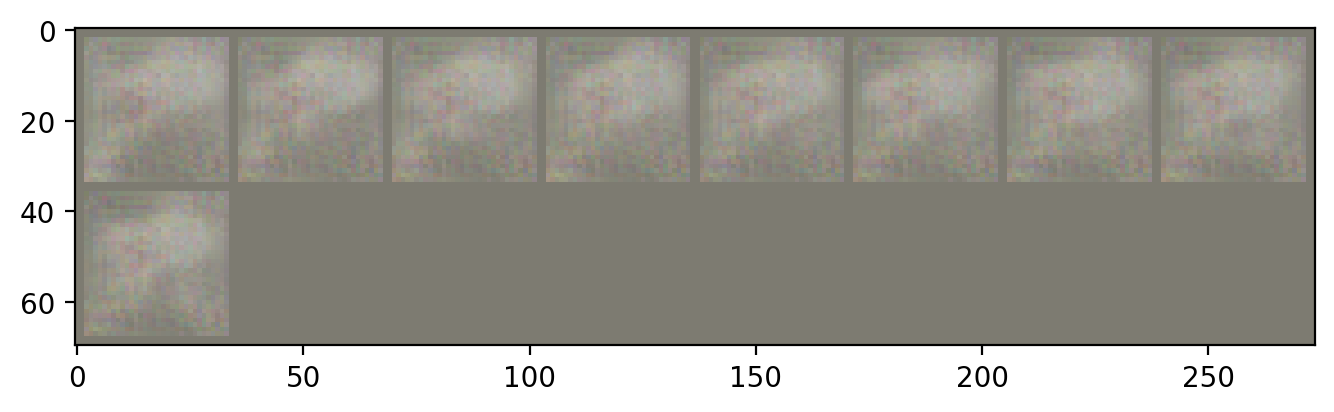

In [28]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=200)
in_image = datamodule.dataset_val.dataset[5][0]
#pre = vae.pre_conv(torch.unsqueeze(datamodule.dataset_val.dataset[1][0].to(device),0))
pre = torch.unsqueeze(datamodule.dataset_val.dataset[5][0],0)
normalize = cifar10_normalization()
mean, st_d = np.array(normalize.mean), np.array(normalize.std)
batch_tensor = []
for label in [0,2,3,4,5,6,7,8,9]:

    label_one_hot = F.one_hot(torch.tensor(label), num_classes=10)
    #label_one_hot = label_one_hot.to(device)
    label_one_hot = label_one_hot.to(torch.float32)
    label_high  =vae.one_hot_linear(label_one_hot)
    label_high = label_high.view_as(pre)
    pre = pre + label_high
    out = vae.encoder(pre)
    mu, log_var = vae.fc_mu(out), vae.fc_var(out)

    # sample z from q
    std = torch.exp(log_var / 2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()

    # decoded 
    out_image = vae.decoder(z)
    #print(out_image.shape)
    batch_tensor.append(torch.squeeze(out_image))
batch_tensor = torch.stack(batch_tensor)
print(batch_tensor.shape)
grid_img = make_grid(batch_tensor, n_rows=5, n_cols=5)
print(grid_img.shape)
    


#normalize = cifar10_normalization()
#mean, std = np.array(normalize.mean), np.array(normalize.std)
#img = torch.squeeze(out_image).permute(1, 2, 0).detach().cpu().numpy()# * std + mean
#in_img = in_image.permute(1, 2, 0).detach().numpy() #* std + mean

# PLOT IMAGES
#imshow(img);
#imshow(in_image.permute(1,2,0));
imshow(grid_img.permute(1, 2, 0).numpy()*st_d+mean)
#datamodule.dataset_val.dataset[0]

(<matplotlib.image.AxesImage at 0x79d4eef2b8d0>, 1)

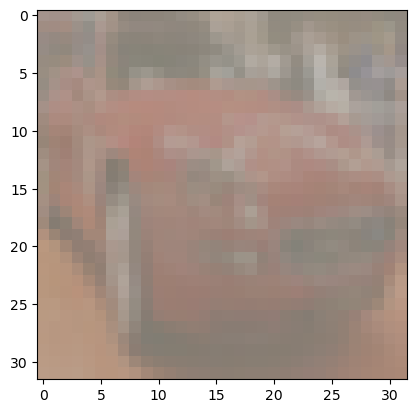

In [29]:
imshow(datamodule.dataset_val.dataset[5][0].permute(1,2,0).numpy()*st_d+mean), datamodule.dataset_val.dataset[5][1]